# COMP90086 Workshop 10

In this workshop, we will discuss generative models for images.

Table of Contents

- Autoencoders
    - Basic Autoencoder
    - Convolutional Autoencoder for Image Denoising
    - (Extra bonus) Convolutional Variational Autoencoder 
- GANs
    - Play with GANs in your browser
    - DCGAN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

from IPython import display

print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.13.0


# 1. Autoencoders

Adapted from the Keras Blog and TensorFlow.org tutorials:
<table class="tfo-notebook-buttons" align="left">
    <td>
    <a target="_blank" href="https://blog.keras.io/building-autoencoders-in-keras.html">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Keras_logo.svg/240px-Keras_logo.svg.png" width=32/>
    View source on blog.keras.io</a>
  </td>   
    <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View source on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

![autoencoder](https://blog.keras.io/img/ae/autoencoder_schema.jpg)
<center>Image source: the Keras Blog</center>

We will introduce autoencoders with three examples: basic autoencoder, image denoising, and convolutional variational autoencoder.

## Load the MNIST dataset and Prepare the data
We will train the basic autoencoder using the MNIST dataset. 

MNIST is a dataset that consists of images of handwritten digits:
* the input data are images of handwritten digits (28×28 pixels with a single 8-bit channel)
* the target is a label in the set $\{0, 1, \ldots, 9\}$

The data is already split into training and test sets. The training set contains 60,000 instances and the test set contains 10,000 instances.

Let's prepare our input data. We're using MNIST digits. We load the data into NumPy arrays using a built-in function from Keras, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [2]:
# Since we only need images from the dataset to encode and decode,
# we won't use the labels.
(train_data, _), (test_data, test_labels) = keras.datasets.mnist.load_data()

print(train_data.shape)

# Normalize and reshape the data
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.



x_train = train_data.reshape((len(train_data), np.prod(train_data.shape[1:])))
x_test = test_data.reshape((len(test_data), np.prod(test_data.shape[1:])))

print(x_train)

print("train_images shape:", x_train.shape)
print("test_images shape:", x_test.shape)

(60000, 28, 28)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
train_images shape: (60000, 784)
test_images shape: (10000, 784)


## (1) Basic autoencoder

Let's start simple, with a single fully-connected neural layer as encoder and as decoder.


Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 32 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.


In [3]:
# This is the size of our encoded representations
latent_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(latent_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Let's also create a separate encoder model:

In [4]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

As well as the decoder model:

In [5]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(latent_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [6]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


Now let's train our autoencoder for 20 epochs:

In [7]:

autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
235/235 [==============================] - 2s 4ms/step - loss: 0.2742 - val_loss: 0.1888
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1701 - val_loss: 0.1532
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1445 - val_loss: 0.1341
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1290 - val_loss: 0.1215
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1184 - val_loss: 0.1129
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1111 - val_loss: 0.1070
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1061 - val_loss: 0.1028
Epoch 8/20
235/235 [==============================] - 1s 4ms/step - loss: 0.1024 - val_loss: 0.0997
Epoch 9/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0996 - val_loss: 0.0974
Epoch 10/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0976 - val_loss: 0.0957

After 20 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representations.

In [8]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 982us/step


Define a `display` function to display ten random images.

In [9]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10 # How many digits we will display

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        plt.title("reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

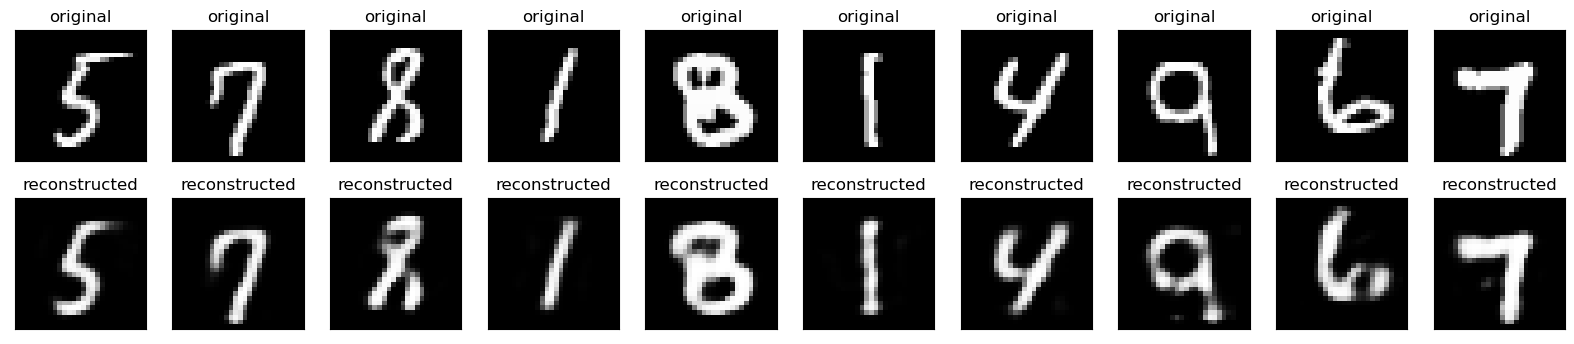

In [10]:
# Display the test data and the reconstructed results
display(x_test, decoded_imgs)

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. The autoencoder is able to recreate digits quite accurately, although there is some information loss.

### Visualise the latent space

The autoencoder has learned a latent representation of the images, which is a compressed representation (in this case, just 32 values) that represent the variation in the MNIST images. We can use [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to visualise the latent space. This is a form of dimensionality-reduction that tries to preserve the distances between points as much as possible -- points that are nearby in the latent space will be nearby in the 2D plot. Different digits are shown in different colours.

In [11]:
from sklearn.manifold import TSNE

# using t-SNE to visualise the latent space 
tsne = TSNE(n_components=2) 
X_tsne = tsne.fit_transform(encoded_imgs) 

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c= test_labels, cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

AttributeError: 'NoneType' object has no attribute 'split'

### Exercise 1: Investigate the latent space representation of MNIST digits

Try changing the size of the latent space. How does this affect the reconstruction results and the organisation of digits in the latent space? Why?

You may notice the representations of different digits overlap in the latent space, particularly when the latent space is very small. Which digits cluster together in the latent space? Do these clusters make sense?

## (2) Convolutional autoencoder for image denoising

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the MNIST dataset by applying random noise to each image. You will then train a deep convolutional autoencoder for image denoising, mapping noisy digits images from the MNIST dataset to clean digits images.

Below we define a `noise` function to add random noise to each image.

In [12]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

Let's reuse the dataset we loaded earlier.

In [13]:
# Reshape the data
print(train_data.shape)
x_train = np.reshape(train_data, (len(train_data), 28, 28, 1))
x_test = np.reshape(test_data, (len(test_data), 28, 28, 1))

print(train_data)
print(x_train)

# Create a copy of the data with added noise
noisy_train_data = noise(x_train)
noisy_test_data = noise(x_test)

# Display the train data and a version of it with added noise
##display(x_train, noisy_train_data)

(60000, 28, 28)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 

Can our autoencoder learn to recover the original digits? Let's find out.

**Build the autoencoder.**

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:

We are going to use the Functional API to build our convolutional autoencoder.

In [14]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        9248

Now we can train our autoencoder using the noisy data as our input and the clean data as our target. We want our autoencoder to learn how to denoise the images.

**This may take a while, please refer to your tutor's demonstration of the results during the workshop.**

In [15]:
print(noisy_train_data.shape)
print(noisy_train_data)
print(x_train.shape)
autoencoder.fit(
    x=noisy_train_data,
    y=x_train,
    epochs=2,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, x_test),
)

(60000, 28, 28, 1)
[[[[0.09762518]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.38012028]
   [0.31790745]]

  [[0.        ]
   [0.80281842]
   [0.        ]
   ...
   [0.48194711]
   [0.        ]
   [0.01534828]]

  [[0.        ]
   [0.43458061]
   [0.        ]
   ...
   [0.        ]
   [0.57595797]
   [0.        ]]

  ...

  [[0.24008537]
   [0.        ]
   [0.45954455]
   ...
   [0.05361672]
   [0.        ]
   [0.        ]]

  [[0.3159234 ]
   [0.36417816]
   [0.        ]
   ...
   [0.        ]
   [0.0593113 ]
   [0.70111973]]

  [[0.        ]
   [0.        ]
   [0.04085981]
   ...
   [0.46097058]
   [0.        ]
   [0.36901835]]]


 [[[0.51666677]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.24539759]]

  [[0.04890802]
   [0.        ]
   [0.        ]
   ...
   [0.69053402]
   [0.15940574]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.11298771]
   [0.25074038]
   [0.        ]]

  ...

  [[0.        ]
   [

313/313 [==============================] - 3s 8ms/step


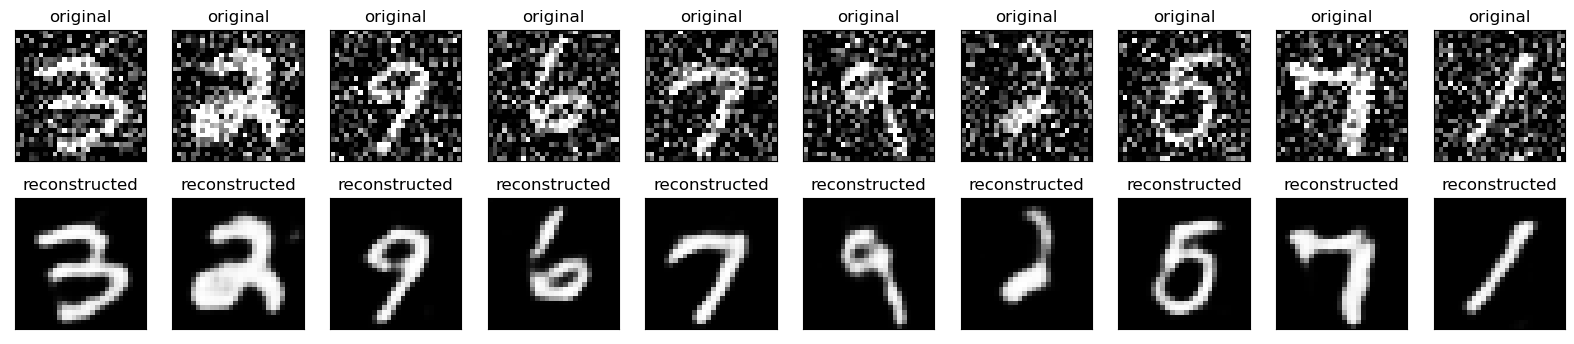

In [16]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

## (3) Extra bonus: Convolutional Variational Autoencoder

Variational autoencoders are a slightly more modern and interesting take on autoencoding.

What is a variational autoencoder? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

Because a VAE is a more complex example, your could refer to the standalone script below:

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

</table>

# 2. Generative Adversarial Networks (GANs)

## (1) Warm-up [Play with GANs in your browser!](https://poloclub.github.io/ganlab/)

### GANs, Autoencoders and VAEs
Generative adversarial networks (GANs) are algorithmic architectures that use two neural networks, pitting one against the other (thus the “adversarial”) in order to generate new, synthetic instances of data that can pass for real data. They are used widely in image generation, video generation and voice generation.

It may be useful to compare generative adversarial networks to other neural networks, such as autoencoders and variational autoencoders.

Autoencoders encode input data as vectors. They create a hidden, or compressed, representation of the raw data. They are useful in dimensionality reduction; that is, the vector serving as a hidden representation compresses the raw data into a smaller number of salient dimensions. Autoencoders can be paired with a so-called decoder, which allows you to reconstruct input data based on its hidden representation.

Variational autoencoders are generative algorithm that add an additional constraint to encoding the input data, namely that the hidden representations are normalized. Variational autoencoders are capable of both compressing data like an autoencoder and synthesizing data like a GAN. However, while GANs generate data in fine, granular detail, images generated by VAEs tend to be more blurred.

(Source of the above introduction: [Pathmind](https://wiki.pathmind.com/generative-adversarial-network-gan))


## (2) DCGAN

We will introduce how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/abs/1511.06434) (DCGAN). We will still use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

Adapted from TensorFlow.org tutorials and Keras.io guides:
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View source on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
   <td>
    <a target="_blank" href="https://keras.io/guides/writing_a_training_loop_from_scratch/">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Keras_logo.svg/240px-Keras_logo.svg.png" width=32/>
    View source on keras.io</a>
  </td>  

</table>

### Load and prepare the dataset

Let's reimport the dataset to omit the modifications made earlier.

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5  # Normalize the images to [-1, 1]

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
x_test = (x_test - 127.5) / 127.5  # Normalize the images to [-1, 1]

print("train_images shape:", x_train.shape)
print("test_images shape:", x_test.shape)

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Create the models

A GAN is made of two parts: a "generator" model that maps points in the latent space to points in image space, a "discriminator" model, a classifier that can tell the difference between real images (from the training dataset) and fake images (the output of the generator network).

<img style="float: ;" src="https://www.tensorflow.org/images/gan/dcgan.gif" width=600 height=500>
<center>(Image courtesy: tensorflow.org)</center>

A GAN training loop looks like this:

- (1) Train the generator. 
    - Sample random points in the latent space. 
    - Turn the points into fake images via the "generator" network. 
    - Get a batch of real images and combine them with the generated images. 
    - Train the "generator" model to "fool" the discriminator and classify the fake images as real.

- (2) Train the discriminator. 
    - Sample a batch of random points in the latent space. 
    - Turn the points into fake images via the "generator" model. 
    - Get a batch of real images and combine them with the generated images. 
    - Train the "discriminator" model to classify generated vs. real images.

Let's implement this training loop. 

#### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#### The Discriminator
Then, create the discriminator meant to classify fake vs real digits. The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

#### Define the loss and optimizers
Define loss functions and optimizers for both models.

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Save checkpoints

This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.




In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### Generate and save images

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#### Define the training loop

In [ ]:
EPOCHS = 50 # In practice you need at least 20 epochs to generate nice digits.
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress after each epoch
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for each epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

### Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. 

To train your own model, run:

`train(train_dataset, EPOCHS)`

To restore the latest checkpoint with your own model, run:

`checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))`

To save time, we will use the prepared checkpoints directly in the workshop.

In [ ]:
# Optional: Disable Tensorflow verbose logging output
import logging
tf.get_logger().setLevel(logging.ERROR) # or any {DEBUG, INFO, WARNING, ERROR, CRITICAL}

In [ ]:
## Restore the pre-trained checkpoints
# checkpoint.restore("./pretrained_checkpoints/ckpt-1") #about 50 epochs
checkpoint.restore("./pretrained_checkpoints/ckpt-2") #about 100 epochs

In [ ]:
predictions = generator(seed, training=False)

In [ ]:
# Display the results
fig = plt.figure(figsize=(4, 4))

for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.show()

### Exercise 2: Check the Discriminator output for real and fake images

Run some real images (from a test set) and fake images (N random samples from the Generator) through the Discriminator and check their scores. If the Discriminator is well-trained, it should output positive values for real images, and negative values for fake images.

In [ ]:
# Choose 10 real images for test set and generate 10 fake images from the Generator
real_images = x_test[:10]
noise = tf.random.normal([10, noise_dim])
fake_images = generator(noise, training=False)

display(real_images, fake_images.numpy())

# Run these real/fake images rough the Discriminator and check their scores.
# your code



The top row is the real images for the test set, and the bottom row is the fake images generated from the Generator.

### Solution

In [ ]:
real_output = discriminator(x_test[:10], training=False)
fake_output = discriminator(fake_images, training=False)

print ("Scores for real images",real_output)
print ("Scores for fake images",fake_output)

### Exercise 3: Check that generated images are not just copies of the training set

Is the Generator simply repeating images from its training set? Or has it learned how to create new images?

To check this, generate one random image from the Generator. Compute its similarity (e.g., sum of square pixel difference) to every image in the training set. Return the closest match (or 3 closest matches).

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import heapq
from tqdm import tqdm

# your code

### Solution

In [ ]:
# Generate one random image from the Generator
noise = tf.random.normal([1,100])
gen = generator(noise, training=False)

plt.imshow(gen[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.title("Generated Image")
plt.axis('off')
plt.show()

# Compute its similarity to every image in the training set. 
# We use sum of square pixel difference as the similarity here.
similarity = []
for i in tqdm(range(len(x_train))):
    mse = tf.reduce_mean(tf.square(gen - tf.squeeze(x_train[i])))
    heapq.heappush(similarity, (mse,i))

# Find the three smallest value, i.e. the three most similar index
k = 3
results = []
for _ in range(k):
    results.append(heapq.heappop(similarity))

# Display the three closest matches found
for i, (_,idx) in enumerate(results):
    plt.subplot(1,3,i+1)
    plt.imshow(np.squeeze(x_train[idx]))
    plt.axis('off')
    
plt.title("The 3 closest matches in the training set")
plt.show()

### Exercise 4: Do a linear walk through the latent space
In a well-trained generative model, the latent space should be **continuous** and **complete**. Continuous means that similar images are nearby in the latent space. Complete means that all points in the latent space correspond to real images.

A good way to check this is to do a linear walk through the latent space. Select two random points (A,B) in the Generator's input space. Get N equally-spaced points from A to B (e.g., from `numpy.linspace`) and generate an image for each of those input points.

If the GAN is well-trained, the images should show a smooth transition from A to B (indicating that the latent space is continuous) and every step between those points should look like a realistic image (indicating that the latent space is complete).

In [ ]:
# your code

### Solution

In [ ]:
# Select two random points in the Generator's input space.
noise = tf.random.normal([2, 100])

# Get 50 equally-spaced points from A to B
walking_latent = np.linspace(noise[0], noise[1], 50)
walking_latent_images = generator(walking_latent, training=False)

fig = plt.figure(figsize=(10, 5))

for i in range(walking_latent_images.shape[0]):
    plt.subplot(5, 10, i+1)
    plt.imshow(walking_latent_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

### Exercise 5: Implement [the birthday paradox test](https://arxiv.org/abs/1706.08224)

Ideally, a generative model should be able to produce a wide variety of images. However, in practice GANs usually show some amount of "mode collapse" -- the Generator can only produce a limited number of images. In severe cases of mode collapse, a Generator will only learn to produce a single image.

Less-severe cases of mode collapse are hard to detect, but one way to check for this is the [the birthday paradox test](https://arxiv.org/abs/1706.08224). Choose a value of N and generate N random images. See if you can spot any duplicate images in the set of N. The value of N at which you start seeing duplicates gives you an approximation of the number of images the GAN can produce. If you have a 50% chance of duplicates in a set of N, that suggests that the Generator produces approximately N^2 unique different images.

In [ ]:
N = 50

noise = tf.random.normal([N, noise_dim])
generated_images = generator(noise, training=False)

fig = plt.figure(figsize=(10, 5))

for i in range(generated_images.shape[0]):
    plt.subplot(5, 10, i+1)
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

### Exercise 6

A Generative Adversarial Network is being trained. The developer observes that initially the Generator is creating images that look like patterned snow.  After some training, it is starting to generate blurry images that start to look like the training data. Later the quality of the generated  images increases but the diversity drops.

i) How might the developer measure quality?

A: Inception score

ii) How might the developer measure diversity?

A: Birthday paradox

iii) Why might diversity drop during the later part of training?

A: Discriminator overfits